# Humerus Bone X-Ray Deep Learning

Dataset: https://stanfordmlgroup.github.io/competitions/mura/

# Data Preparation

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/'My Drive'/DS4A_Project/MURA-v1.1
!ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/DS4A_Project/MURA-v1.1
cnn_metrics.png		    humerus		  train_image_paths.csv
data			    model_metrics.png	  train_labeled_studies.csv
elbow			    models		  valid
finger			    pps_all.png		  valid_dists.png
forearm			    shoulder		  valid_extr_dists.png
hand			    train		  valid_image_paths.csv
hu_data.pickle		    train_dists.png	  valid_labeled_studies.csv
hu_history_aug_metrics.png  train_extr_dists.png  wrist


In [2]:
### DEPENDENCIES (for Data Preparation) ###
import os
import pandas as pd
from PIL import Image
from shutil import copyfile
from tqdm.notebook import tqdm as tqdm

In [4]:
def extract_features(df): 
  """
  from filepath, extract extremity, patient_num, and study_num as new columns
  """
  split = df['path'].str.split('/', expand=True) 
  colnames = {2:'extremity', 3:'patient_num', 4:'study_num'}
  split = split.drop(columns = [0,1,5]).rename(columns=colnames) 
  df['extremity'] = split['extremity'].str.slice(3).str.lower()  
  df['patient_num'] = split['patient_num'].str.replace('patient', '')
  df['study_num'] = split['study_num'].str.get(5)
  return df

def extract_label_int(df): 
  """
  from filepath, extract label as ints in new column
  """
  df['label'] = df['path'].str.contains('positive')
  return df

def extract_label_str(df): 
  """
  from filepath, extract label as strs in new column
  """
  label_str = lambda x: ['normal', 'fractured'][int('positive' in x)]
  df['class'] = df['path'].apply(label_str)
  return df

## Training Set
**train_image_paths.csv**: filepaths to 36808 training set images <br>
**train_labeled_studies**: labels for 13457 training set studies <br>  

From _train_image_paths_ ---> create _train_img_ dataframe (granularity: individual images) <br>
From _train_labeled_studies_ --> create _train_stud_ dataframe (granularity: individual studies)



In [5]:
# sample filepaths (to individual images) from training set 
!head -3 train_image_paths.csv

MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png


In [6]:
# read training set filepaths (to individual images) into a dataframe
train_image_paths = pd.read_csv('train_image_paths.csv', 
                                header = None, 
                                names = ['path'])
train_image_paths.info()
train_image_paths.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    36808 non-null  object
dtypes: object(1)
memory usage: 287.7+ KB


,path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [7]:
# extract features from filepaths --> save as train_img dataframe
train_img = train_image_paths.pipe(extract_features).pipe(extract_label_int).pipe(extract_label_str)
train_img.head()

,path,extremity,patient_num,study_num,label,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,shoulder,00001,1,True,fractured
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,shoulder,00001,1,True,fractured
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,shoulder,00001,1,True,fractured
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,shoulder,00002,1,True,fractured
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,shoulder,00002,1,True,fractured


In [8]:
# sample filepaths (to studies + associated labels) from training set
!tail -3 train_labeled_studies.csv

MURA-v1.1/train/XR_HAND/patient11182/study1_negative/,0
MURA-v1.1/train/XR_HAND/patient11183/study1_negative/,0
MURA-v1.1/train/XR_HAND/patient11184/study1_negative/,0


In [9]:
# read training set filepaths (to individual studies + associated labels) into a dataframe
train_labeled_studies = pd.read_csv('train_labeled_studies.csv', 
                                    header = None, 
                                    names = ['path', 'label'])
train_labeled_studies.info() 
train_labeled_studies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13457 entries, 0 to 13456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    13457 non-null  object
 1   label   13457 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 210.4+ KB


,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [10]:
# extract features from filepaths --> save as train_stud dataframe
train_stud = train_labeled_studies.pipe(extract_features).pipe(extract_label_str)
train_stud.head()

,path,label,extremity,patient_num,study_num,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,shoulder,00001,1,fractured
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,shoulder,00002,1,fractured
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,shoulder,00003,1,fractured
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,shoulder,00004,1,fractured
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,shoulder,00005,1,fractured


## Validation Set
**valid_image_paths.csv**: filepaths to 3197 training set images <br>
**valid_labeled_studies**: labels for 1199 training set studies <br>  

From _train_image_paths_ ---> create _train_img_ dataframe (granularity: individual images) <br>
From _train_labeled_studies_ --> create _train_stud_ dataframe (granularity: individual studies)

In [15]:
# sample filepaths (to individual images) from validation set 
!head -3 valid_image_paths.csv

MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image2.png
MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image3.png


In [16]:
# read validation set filepaths (to individual images) into a dataframe
valid_image_paths = pd.read_csv('valid_image_paths.csv', 
                                header = None, 
                                names = ['path'])
valid_image_paths.info()
valid_image_paths.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    3197 non-null   object
dtypes: object(1)
memory usage: 25.1+ KB


,path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [17]:
# extract features from filepaths --> save as valid_img dataframe
valid_img = valid_image_paths.pipe(extract_features).pipe(extract_label_int).pipe(extract_label_str)
valid_img.head()

,path,extremity,patient_num,study_num,label,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,wrist,11185,1,True,fractured
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,wrist,11185,1,True,fractured
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,wrist,11185,1,True,fractured
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,wrist,11185,1,True,fractured
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,wrist,11186,1,True,fractured


In [18]:
# sample filepaths (to studies + associated labels) from validation set
!tail -3 valid_labeled_studies.csv

MURA-v1.1/valid/XR_FINGER/patient11966/study1_negative/,0
MURA-v1.1/valid/XR_FINGER/patient11967/study1_negative/,0
MURA-v1.1/valid/XR_FINGER/patient11738/study1_negative/,0


In [19]:
# read validation set filepaths (to individual studies + associated labels) into a dataframe
valid_labeled_studies = pd.read_csv('valid_labeled_studies.csv', 
                                    header = None, 
                                    names = ['path', 'class'])
valid_labeled_studies.info() 
valid_labeled_studies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1199 non-null   object
 1   class   1199 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


,path,class
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1


In [20]:
# extract features from filepaths --> save as valid_stud dataframe
valid_stud = valid_labeled_studies.pipe(extract_features).pipe(extract_label_str)
valid_stud.head()

,path,class,extremity,patient_num,study_num
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,fractured,wrist,11185,1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,fractured,wrist,11186,1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,fractured,wrist,11186,2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,fractured,wrist,11186,3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,fractured,wrist,11187,1


## Construct Distinct Image Directories

In [21]:
pth_beginning = '/gdrive/My Drive/DS4A_Project/'
dest_general_img = os.path.join(pth_beginning, 'MURA-v1.1/{}/{}/{}/{}_{}_{}_{}.png')

def copy_images(df_paths, train_or_val, full=True): 
  pairs = df_paths.index
  for pair in pairs: 
    extremity, label = pair
    lst = df_paths[extremity, label]
    for idx, l in enumerate(tqdm(lst)):  
      copyfile(pth_beginning + l, 
               dest_general_img.format([extremity, 'data'][int(full)], 
                                        train_or_val, label, extremity, 
                                        idx+1, train_or_val[:5], label[:4]))

train_paths = train_img.groupby(['extremity', 'class'])['path'].agg(list)
valid_paths = valid_img.groupby(['extremity', 'class'])['path'].agg(list)

In [ ]:
# run ONCE --> leave alone
# (full dataset) --> Data [Normal, Fractured]
copy_images(train_paths[:5], 'train')
copy_images(valid_paths, 'validation')

In [ ]:
# run ONCE --> leave alone
# (per extremity dataset) --> Extremity [Normal, Fractured]
copy_images(train_paths, 'train', full=False)
copy_images(valid_paths, 'validation', full=False)

# Exploratory Data Analysis 


In [17]:
### DEPENDENCIES ###
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


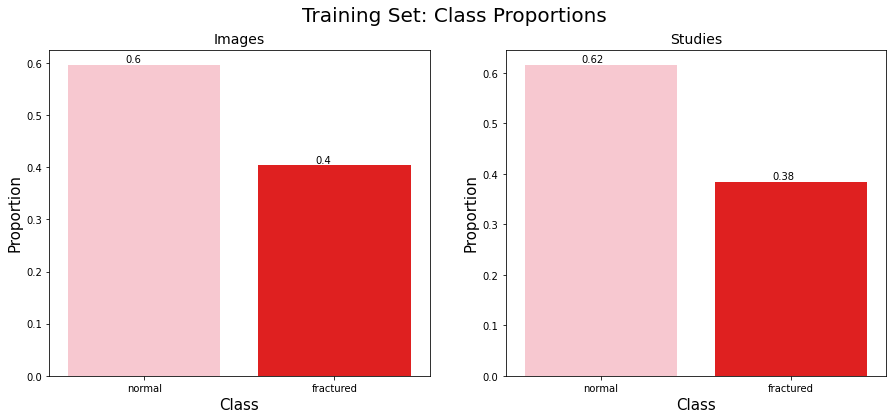

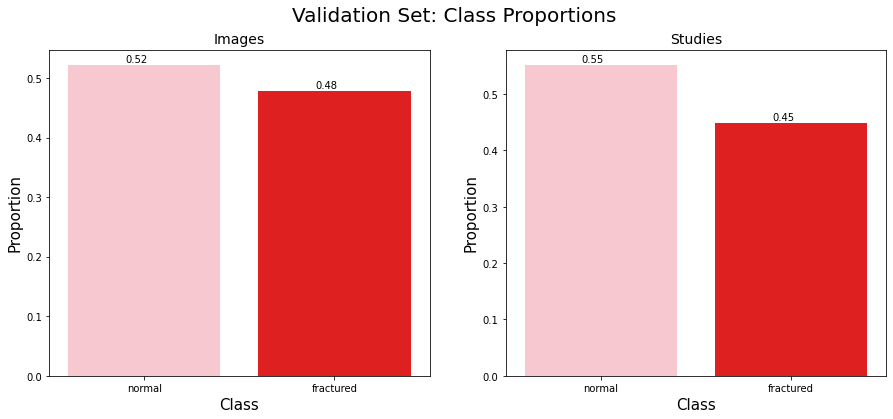

In [18]:
# visualize distribution of images/studies per class over training and validation sets

# ------------------------------------------------------------ #
def plot_class(df, granularity): # helper 
  props = df['class'].value_counts(normalize=True)
  ax = sns.barplot(props.index,
                   props, 
                   palette = {'normal':'pink', 'fractured':'red'})
  for p in ax.patches: 
    ax.annotate(round(p.get_height(), 2),
                (p.get_x()+.3, 
                 p.get_height() + p.get_height()*0.01))
  plt.title(granularity, fontsize=14)
  plt.xlabel('Class', fontsize=15)
  plt.ylabel('Proportion', fontsize=15)

def plot_class_distributions(df_img, df_stud, suptitle, filename): 
  plt.figure(figsize=(15, 6))
  plt.suptitle(suptitle, fontsize=20)

  plt.subplot(1, 2, 1)
  plot_class(df_img, 'Images')

  plt.subplot(1, 2, 2)
  plot_class(df_stud, 'Studies')

  plt.savefig(filename)
# ------------------------------------------------------------ #

plot_class_distributions(train_img, train_stud, 'Training Set: Class Proportions', 'train_dists.png')
plot_class_distributions(valid_img, valid_stud, 'Validation Set: Class Proportions', 'valid_dists.png')

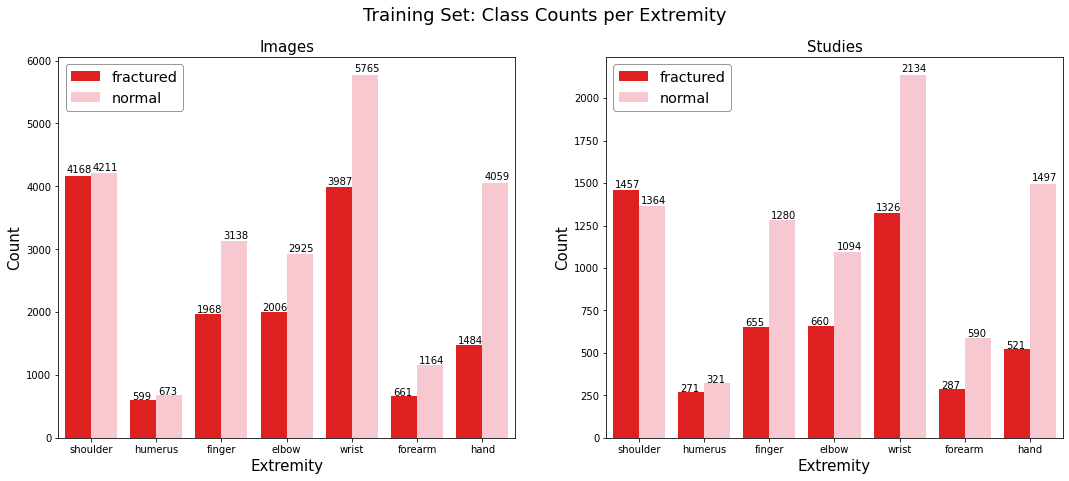

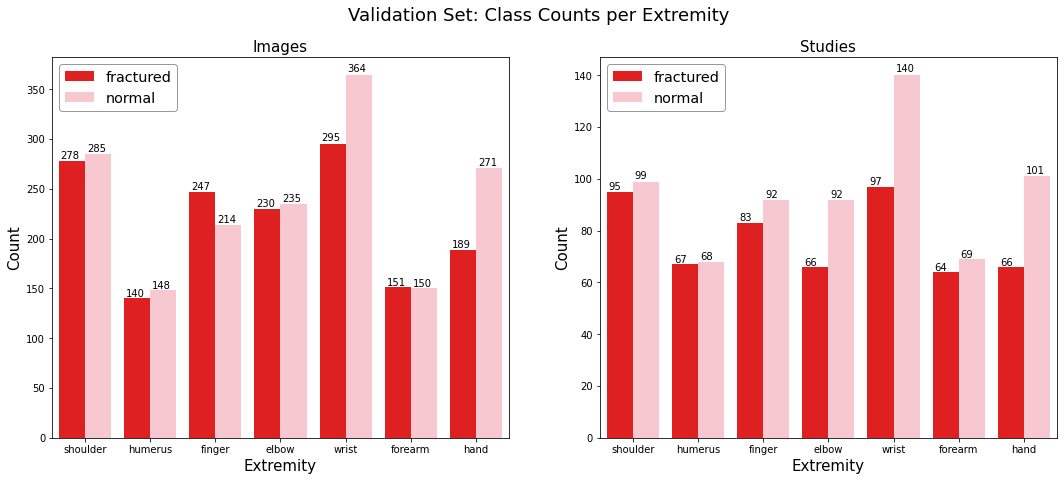

In [19]:
# visualize distribution of images/studies per class per extremity over training and validation sets

# ------------------------------------------------------------ #
def plot_extr(df, granularity): # helper 
  ax = sns.countplot(data = df,
                     x = 'extremity', 
                     hue ='class', 
                     palette = {'normal':'pink', 'fractured':'red'},
                     order = train_img['extremity'].unique())
  for p in ax.patches: 
    ax.annotate(p.get_height().astype(int), 
                (p.get_x() + 0.03, 
                 p.get_height() + p.get_height()*0.01))
  plt.legend(loc = 'upper left', frameon = True, edgecolor='grey', fontsize='x-large')
  plt.title(granularity, fontsize=15)
  plt.xlabel('Extremity', fontsize=15)
  plt.ylabel('Count', fontsize=15)

def plot_extr_distributions(df_img, df_stud, suptitle, filename): 
  plt.figure(figsize=(18, 7))
  plt.suptitle(suptitle, fontsize=18)

  plt.subplot(1, 2, 1)
  plot_extr(df_img, 'Images')

  plt.subplot(1, 2, 2)
  plot_extr(df_stud, 'Studies')

  plt.savefig(filename)
# ------------------------------------------------------------ #

suptitle_train = 'Training Set: Class Counts per Extremity'
plot_extr_distributions(train_img, train_stud, suptitle_train, 'train_extr_dists.png')
suptitle_valid = 'Validation Set: Class Counts per Extremity'
plot_extr_distributions(valid_img, valid_stud, suptitle_valid, 'valid_extr_dists.png')

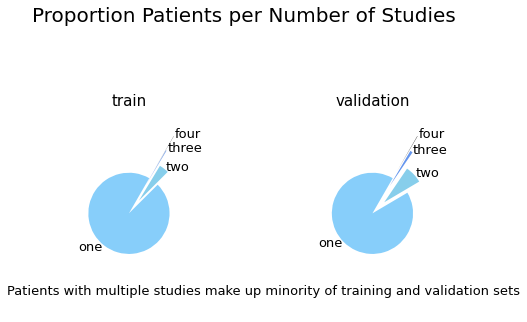

In [20]:
# visualize distribution of patients 
explode = [(0, 0.2), (0, 0.2, 0.4), (0, 0.2, 0.4, 0.6)]
labels = ('one', 'two', 'three', 'four')

# --------------------------------------------------------------------------- #
def get_sizes(df): #helper
  ssp = df[['patient_num', 'study_num']].groupby('patient_num').max()
  ssp_grouped = ssp['study_num'].value_counts(normalize=True)
  return list(ssp_grouped)

def plot_pps(df, set_name): #helper
  sizes = get_sizes(df)
  n = len(sizes)
  plt.pie(x = sizes, 
          explode = explode[n-2], 
          labels = labels[:n],
          startangle = 60,
          colors = ['lightskyblue', 'skyblue', 'cornflowerblue', 'black'],
          labeldistance = 1.05,
          radius = 0.5,
          textprops = dict(size=13))  
  plt.title(set_name, fontsize=15)

def plot_pps_pie(df_train, df_valid, suptitle, filename, text = False,): 
  plt.figure(figsize = (8, 6))
  plt.suptitle(suptitle, fontsize=20)

  plt.subplot(1, 2, 1)
  plot_pps(df_train, 'train')

  plt.subplot(1, 2, 2)
  plot_pps(df_valid, 'validation')

  if text: 
    text = 'Patients with multiple studies make up minority of training and validation sets'
    plt.text(-4.5, -1, text, fontsize=13)

  plt.savefig(filename)
# --------------------------------------------------------------------------- #

plot_pps_pie(train_stud, valid_stud, 
             suptitle=('Proportion Patients per Number of Studies'),  
             filename = 'pps_all.png', 
             text=True)

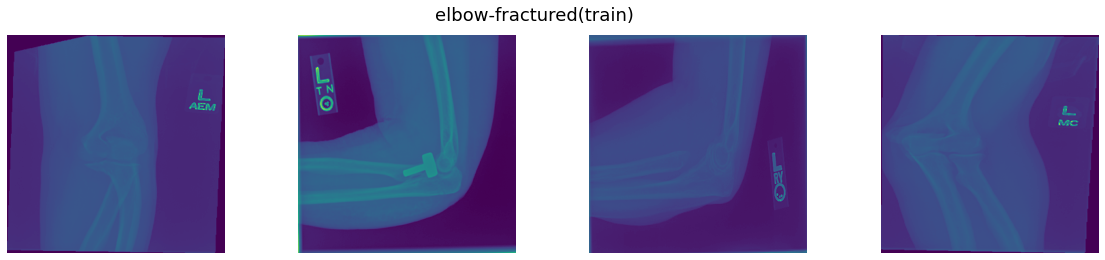

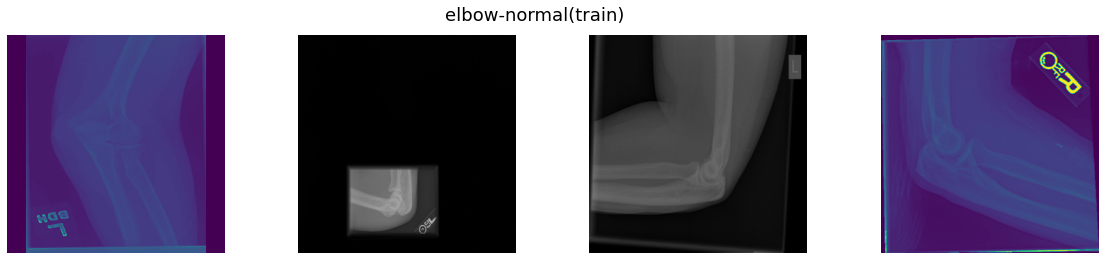

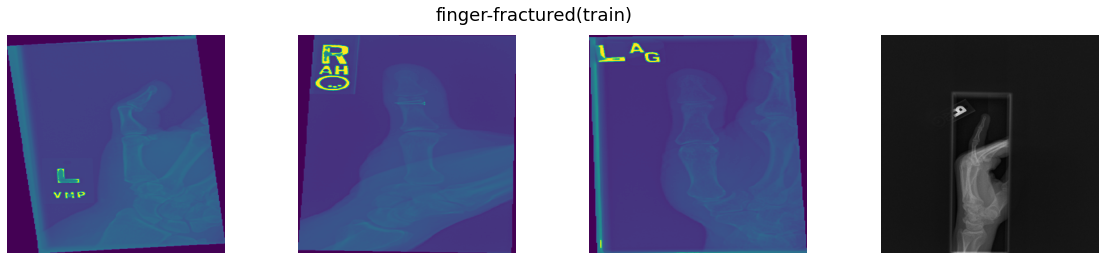

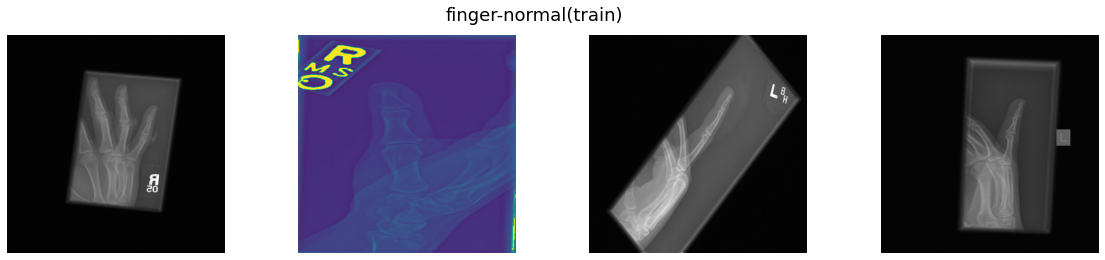

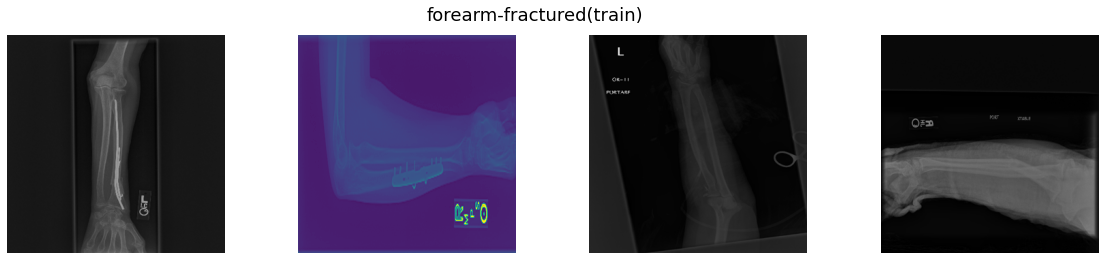

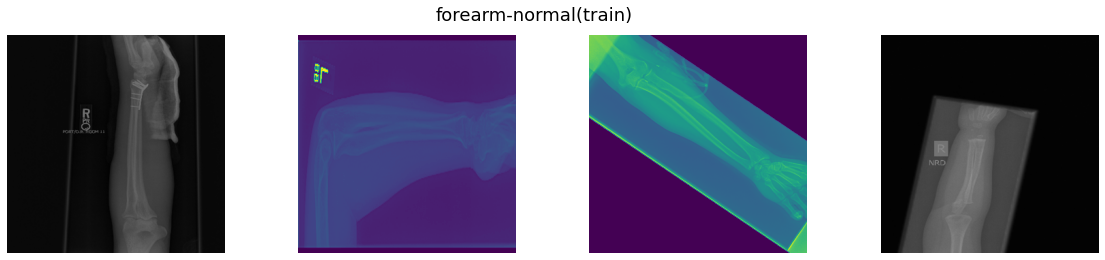

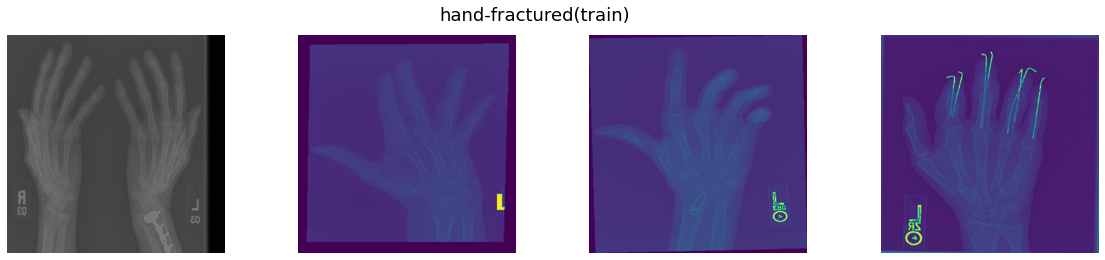

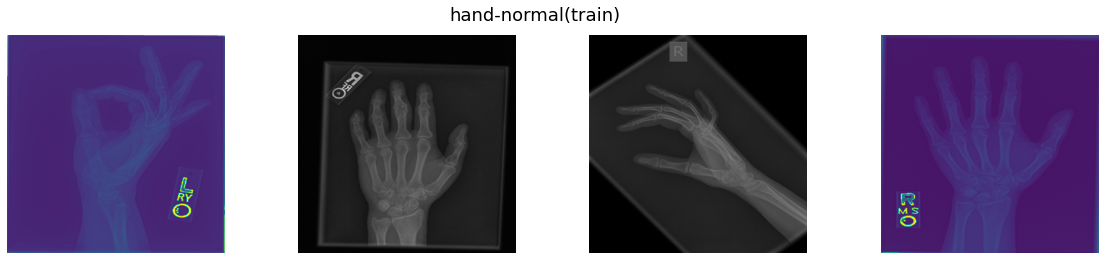

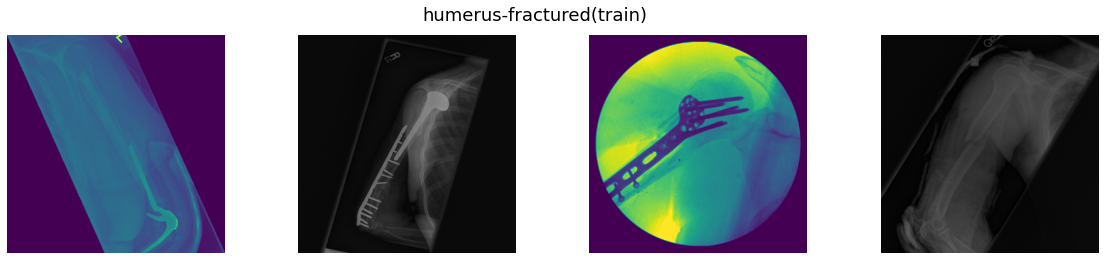

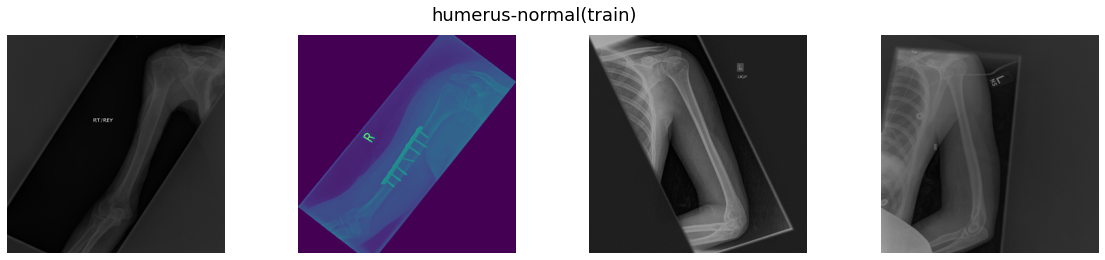

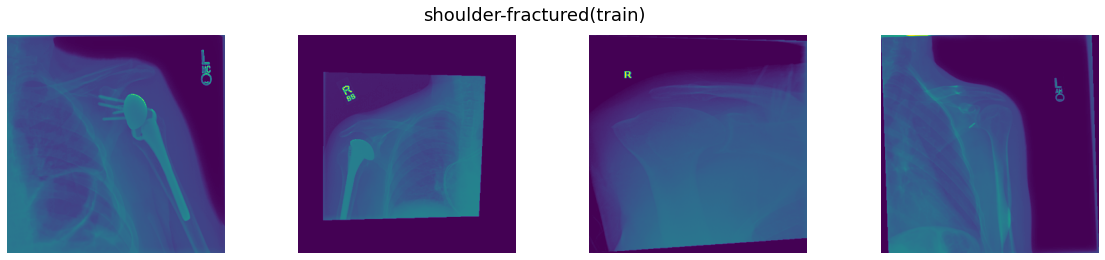

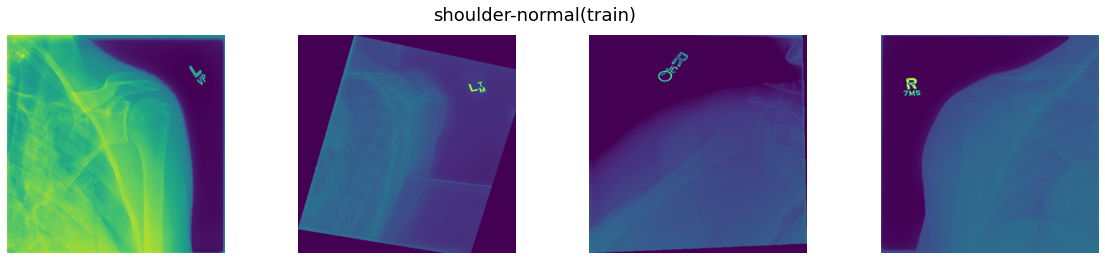

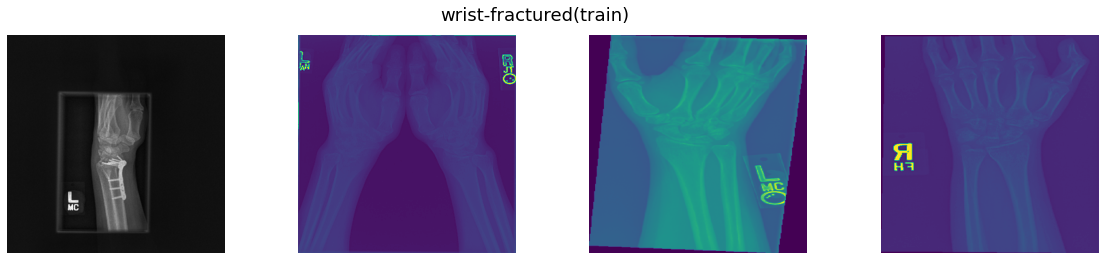

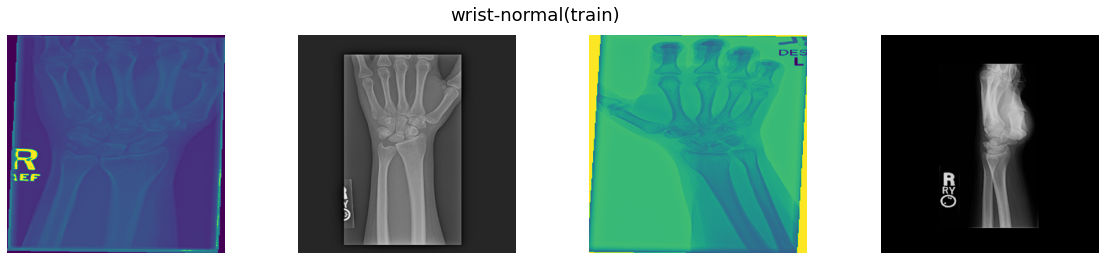

In [ ]:
# ppe = (list of) paths per extremity
# displaying 4 random images per extremity-class for training set

path_start = '/gdrive/My Drive/DS4A_Project/'

def plot_extr_images(df, data_set): 

  df_ppe = df.groupby(['extremity', 'class'])['path'].agg(list)
  for extremity, path_list in df_ppe.items(): 
    plt.figure(figsize=(20, 4))
    plt.suptitle('-'.join(extremity) + data_set, fontsize=18)
  
    list_index = np.random.choice(len(path_list), 
                                  size=4, 
                                  replace=False)
    for i in range(4): 
      plt.subplot(1, 4, i+1)
      path = path_start + path_list[list_index[i]]
      img = Image.open(path)
      img = img.resize((320, 320)) 
      plt.imshow(img)
      plt.axis('off')

    plt.savefig('samples.png')

plot_extr_images(train_img, data_set = '(train)')

# Model Inputs Preparation

In [21]:
import pickle
import numpy as  np
from random import shuffle

## Raw Inputs+Labels

In [22]:
train_path = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/{}/train/{}'
validation_path = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/{}/validation/{}'

def get_data_list(lst, DIR, size, convert): 
  data = []
  for img in tqdm(lst): 
    label = np.array([1]) if 'norm' in img else np.array([0])
    path = os.path.join(DIR, img)
    if 'DS_Store' not in path: 
      with Image.open(path) as img: 
        img = img.convert(convert)
        img = img.resize(size)
        data.append([np.array(img), label])
  return data

def load_data(DIR_normal, DIR_frac, img_size, convert, sample_size = None, all = False): 

  if all: 
    norm_lst = os.listdir(DIR_normal)
    frac_lst = os.listdir(DIR_frac)                              
  else: 
    norm_lst = np.random.choice(os.listdir(DIR_normal),
                                sample_size // 2, 
                                replace = False)
    frac_lst = np.random.choice(os.listdir(DIR_frac), 
                                sample_size // 2,
                                replace = False)
  data = get_data_list(norm_lst, DIR_normal, img_size, convert)
  frac_data = get_data_list(frac_lst, DIR_frac, img_size, convert)
  data.extend(frac_data)
  shuffle(data)
  return data

def shape_data(train, validation, shape, c): 
  x_train = np.array([i[0] for i in train]).reshape(-1, shape[0], shape[1], c)
  y_train = np.array([i[1] for i in train])
  x_test = np.array([i[0] for i in validation]).reshape(-1, shape[0], shape[1], c)
  y_test = np.array([i[1] for i in validation])
  return x_train, y_train, x_test, y_test

In [ ]:
# raw data inputs + labels (for cnn)
hu_train_path_norm = train_path.format('humerus', 'normal')
hu_train_path_frac = train_path.format('humerus', 'fractured')
hu_valid_path_norm = validation_path.format('humerus', 'normal')
hu_valid_path_frac = validation_path.format('humerus', 'fractured')

hu_train_data = load_data(hu_train_path_norm, 
                          hu_train_path_frac, 
                          (320, 320), 'RGB', 
                          all = True)
hu_valid_data = load_data(hu_valid_path_norm, 
                          hu_valid_path_frac, 
                          (320, 320), 'RGB', 
                          all = True)

x_hu_train, y_hu_train, x_hu_test, y_hu_test = shape_data(hu_train_data,
                                                          hu_valid_data, 
                                                          (320, 320), 3)

In [ ]:
# save raw inputs + labels (for cnn)
hu_data = [x_hu_train, y_hu_train, x_hu_test, y_hu_test]
with open('hu_data.pickle', 'wb') as f: 
  pickle.dump(hu_data, f)

## Generator Inputs+Labels

In [24]:
from keras.preprocessing.image import ImageDataGenerator

def get_generators(train_path, valid_path, size, batchsize): 

  def create(datagen, path): 
    return datagen.flow_from_directory(path, 
                                       target_size = size,
                                       batch_size = batchsize,  
                                       class_mode = 'binary')

  train_datagen = ImageDataGenerator(rescale = 1./255, 
                                     rotation_range = 30, 
                                     vertical_flip = True, 
                                     horizontal_flip = True, 
                                     shear_range = 0.2)
  valid_datagen = ImageDataGenerator(rescale = 1./255)

  return create(train_datagen, train_path), create(valid_datagen, valid_path)

Using TensorFlow backend.


In [27]:
# formatting purpose: possibly try other extremities
train_path_gen = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/{}/train'
validation_path_gen = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/{}/validation'

hu_train_path = train_path_gen.format('humerus')
hu_valid_path = validation_path_gen.format('humerus')
hu_train_gen, hu_valid_gen = get_generators(hu_train_path, 
                                            hu_valid_path, 
                                            (320, 320), 
                                            batchsize=32)

Found 1272 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


# Model Training

In [28]:
# Update Keras
import keras
keras.__version__

'2.3.1'

In [29]:
# Dependencies
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, ELU
from keras.optimizers import Adam

import os
import pickle
import numpy as np
from PIL import Image
from random import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [30]:
# Callbacks
model_path = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/models/cnn'
model_path += '{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.hdf5'
callbacks = [ModelCheckpoint(model_path)]

model_path_aug = '/gdrive/My Drive/DS4A_Project/MURA-v1.1/models/cnn'
model_path_aug += '{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.hdf5'
callbacks_aug = [ModelCheckpoint(model_path_aug)]

In [31]:
# CNN
elu_alpha = 1.8

model = Sequential()
model.add(Conv2D(32, kernel_size = 5, input_shape = (320, 320, 3)))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 3))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Conv2D(64, kernel_size = 3))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Conv2D(96, kernel_size = 3))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Conv2D(96, kernel_size = 3))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Conv2D(128, kernel_size = 3))
model.add(ELU(alpha=elu_alpha))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256))
model.add(ELU(alpha=elu_alpha))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(ELU(alpha=elu_alpha))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = Adam(lr = 0.00005), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
model.name = 'simple_cnn'
model.summary()

Model: "simple_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 316, 316, 32)      2432      
_________________________________________________________________
elu_1 (ELU)                  (None, 316, 316, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 158, 158, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 156, 156, 64)      18496     
_________________________________________________________________
elu_2 (ELU)                  (None, 156, 156, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 78, 78, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 76, 76, 64)        3

In [32]:
def fit_model(model, train_x, train_y, valid_x, valid_y, epochs, callbacks, gen = False): 
  history = model.fit(train_x, train_y, 
                      batch_size = 16, 
                      epochs = epochs, 
                      callbacks = callbacks, 
                      validation_data = (valid_x, valid_y))
  return history

def fit_model_gen(model, train_gen, valid_gen, batchsize, epochs, callbacks):
  history = model.fit_generator(train_gen, 
                                validation_data = valid_gen, 
                                steps_per_epoch = len(train_gen.filenames) // batchsize, 
                                validation_steps = len(valid_gen.filenames) // batchsize, 
                                epochs = epochs, 
                                callbacks = callbacks)
  return history

In [33]:
def plot_results(h, suptitle, filename): 

  def plot(train, val, title, y_label, colors): 
    plt.plot(train, color = colors[0])
    plt.plot(val, color = colors[1])
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.legend(['train', 'validation'])

  acc, val_acc = h.history['accuracy'], h.history['val_accuracy']
  loss, val_loss = h.history['loss'], h.history['val_loss']

  plt.figure(figsize=(7, 10))
  plt.suptitle(suptitle, fontsize = 18)
  plt.subplot(2, 1, 1)
  plot(acc, val_acc, 'Accuracy vs Epoch#', 'Accuracy', ['skyblue', 'indigo'])
  plt.subplot(2, 1, 2)
  plot(loss, val_loss, 'Loss vs Epoch#', 'Loss', ['gold', 'crimson'])
  plt.savefig(filename)

In [ ]:
# Fit Model - No Augmentation - Humerus
with open('hu_data.pickle', 'rb') as f: 
  hu_data = pickle.load(f)
x_hu_train, y_hu_train, x_hu_test, y_hu_test = hu_data

history = fit_model(model, x_hu_train, y_hu_train, x_hu_test, y_hu_test, 70, callbacks)

Train on 1272 samples, validate on 288 samples
Epoch 1/70
1272/1272 [==============================] - 65s 51ms/step - loss: 1.7225 - accuracy: 0.5275 - val_loss: 0.8063 - val_accuracy: 0.5104
Epoch 2/70
1272/1272 [==============================] - 64s 51ms/step - loss: 1.2974 - accuracy: 0.5259 - val_loss: 0.7858 - val_accuracy: 0.5382
Epoch 3/70
1272/1272 [==============================] - 64s 50ms/step - loss: 1.0968 - accuracy: 0.5409 - val_loss: 0.7993 - val_accuracy: 0.5312
Epoch 4/70
1272/1272 [==============================] - 65s 51ms/step - loss: 1.0538 - accuracy: 0.5527 - val_loss: 0.6944 - val_accuracy: 0.6215
Epoch 5/70
1272/1272 [==============================] - 64s 50ms/step - loss: 0.9829 - accuracy: 0.5574 - val_loss: 0.7467 - val_accuracy: 0.5660
Epoch 6/70
1272/1272 [==============================] - 64s 51ms/step - loss: 0.9813 - accuracy: 0.5653 - val_loss: 0.6671 - val_accuracy: 0.6146
Epoch 7/70
1272/1272 [==============================] - 65s 51ms/step - loss:

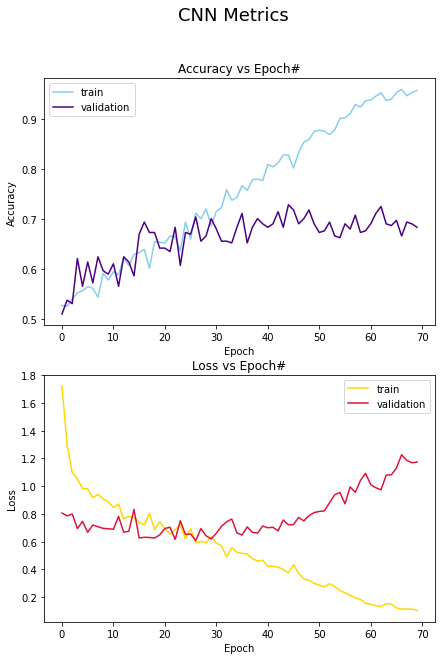

In [ ]:
plot_results(history, 'CNN Metrics', 'cnn_metrics.png')

In [ ]:
# before running, set model input dimensions to contain 3 channels
history_aug = fit_model_gen(model, hu_train_gen, hu_valid_gen, 32, 250, callbacks_aug)

Epoch 1/250
39/39 [==============================] - 429s 11s/step - loss: 0.8318 - accuracy: 0.4976 - val_loss: 0.6792 - val_accuracy: 0.5243
Epoch 2/250
39/39 [==============================] - 65s 2s/step - loss: 0.7319 - accuracy: 0.5395 - val_loss: 0.7332 - val_accuracy: 0.5451
Epoch 3/250
39/39 [==============================] - 58s 1s/step - loss: 0.7246 - accuracy: 0.5315 - val_loss: 0.6783 - val_accuracy: 0.5312
Epoch 4/250
39/39 [==============================] - 58s 1s/step - loss: 0.7395 - accuracy: 0.5161 - val_loss: 0.6656 - val_accuracy: 0.4965
Epoch 5/250
39/39 [==============================] - 58s 1s/step - loss: 0.7234 - accuracy: 0.5274 - val_loss: 0.6520 - val_accuracy: 0.5694
Epoch 6/250
39/39 [==============================] - 58s 1s/step - loss: 0.7115 - accuracy: 0.5347 - val_loss: 0.6485 - val_accuracy: 0.5694
Epoch 7/250
39/39 [==============================] - 58s 1s/step - loss: 0.6937 - accuracy: 0.5726 - val_loss: 0.6823 - val_accuracy: 0.5625
Epoch 8/250

In [ ]:
plot_results(history_aug, 'CNN Metrics (+Augmentation)', 'cnn_metrics_aug.png')